In [1]:
import numpy as np
import pandas as pd

from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import os
import sys
BASE_PATH = os.path.realpath('..')
DATASETS_DIR = os.path.join(BASE_PATH, 'datasets')
LIB_DIR = os.path.join(BASE_PATH,'lib')
if LIB_DIR[:-3] not in sys.path:
    sys.path.append(LIB_DIR[:-3])

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from importlib import reload

In [2]:
RESULTS_DIR = os.path.join(BASE_PATH, 'results')

In [3]:
from lib import fca_interp as fcai

In [4]:
from lib.utils_ import powerset

In [5]:
from importlib import reload

In [6]:
from copy import copy, deepcopy

# Load data

In [7]:
from lib import fca_interp as fcai

In [8]:
ds = pd.read_csv(DATASETS_DIR+'/mango.csv', index_col=0)
ds.head()

,color,firm,smooth,form,fruit
title,,,,,
apple,yellow,False,True,round,True
grapefruit,yellow,False,False,round,True
kiwi,green,False,False,oval,True
plum,blue,False,True,oval,True
toy cube,green,True,True,cubic,False


In [393]:
mvcntx = fcai.MultiValuedContext(ds.drop('fruit',1), cat_attrs=['color','form'])

In [412]:
fm = fcai.FormalManager(mvcntx)
fm.construct_concepts()
fm._concepts = list(fm.get_concepts()) + [fm.get_bottom_concept()]
for idx, c in enumerate(fm.sort_concepts()):
    c._idx = idx
fm.construct_lattice(use_tqdm=True)

In [414]:
fig = fm.get_plotly_fig()
fig.show()

In [415]:
connections_dict = {}
for c in fm.get_concepts():
    connections_dict[c.get_id()] = [ln_idx for ln_idx in c.get_lower_neighbs()]
level_widths = {}
nodes_by_level_dict = {}
for c in fm.get_concepts():
    lvl = c.get_level()
    level_widths[lvl] = level_widths.get(lvl, 0) + 1
    nodes_by_level_dict[lvl] = nodes_by_level_dict.get(lvl, []) + [c.get_id()]

pos = fm._get_concepts_position(fm.get_concepts(), level_widths, None, None)

In [416]:
pos_old = pos.copy()

In [417]:
import networkx as nx

In [418]:
G = nx.from_dict_of_lists(connections_dict)
nx.set_node_attributes(G, pos, 'pos')

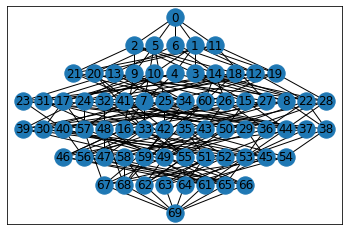

In [419]:
nx.draw_networkx(G, pos=pos)

In [420]:
class Line:
    def __init__(self, pA, pB, idA, idB):
        p0, p1 = sorted([pA, pB], key=lambda p: -p[1])
        self.pA = pA
        self.pB = pB
        self.idA = idA
        self.idB = idB
        self._x0 = p0[0]
        self._y0 = p0[1]
        self._x1 = p1[0]
        self._y1 = p1[1]
        
        self.k = (self._x0-self._x1)/(self._y0-self._y1)
        self.b = self._x0 - self.k*self._y0

        
    def has_intersection(self, line):
        if self.k == line.k: #lines are parallel
            return False
        
        Y_intersect = (line.b - self.b)/(self.k - line.k)
        y_top = min([line._y0, self._y0])
        y_bottom = max([line._y1, self._y1])
        if y_bottom<=Y_intersect and Y_intersect<=y_top:
            return True
        return False
    
    def covers_line(self, line):
        if self.k != line.k or self.b != line.b:
            return False
        
        if self._y0>line._y0: # self выше line
            if line._y0>self._y1:
                return True
        else: # self ниже line
            if self._y0>line._y1: 
                return True
        return False
            

In [421]:
def get_lines(connections_dict, pos):
    lines = {}
    for v0, v1s in connections_dict.items():
        for v1 in v1s:
            lines[(v0,v1)] = Line(pos[v0], pos[v1], v0, v1)
    return lines

In [422]:
def calc_intersections_and_coverings(lines):
    lines = list(lines.values())
    n_intersections = 0
    intersect_stat = {}
    n_coverings = 0
    cover_stat = {}
    for idx0, l0 in enumerate(lines[:-1]):
        for idx1, l1 in enumerate(lines[idx0+1:]):
            if l0.has_intersection(l1):
                n_intersections += 1
                for v in set([l0.idA, l0.idB, l1.idA, l1.idB]):
                    intersect_stat[v] = intersect_stat.get(v,0)+1
                
            if l0.covers_line(l1):
                n_coverings += 1
                for v in set([l0.idA, l0.idB, l1.idA, l1.idB]):
                    cover_stat[v] = cover_stat.get(v,0)+1
    return n_intersections, n_coverings, intersect_stat, cover_stat

In [423]:
lines = get_lines(connections_dict, pos)
len(lines)

184

In [424]:
hist_ds = []

In [425]:
for idx in tqdm(range(len(get_lines(connections_dict, pos_old)))):
    hist = {}
    n_intersections, n_coverings, intersect_stat, cover_stat = calc_intersections_and_coverings(lines)
    mean_angle = np.mean([abs(l.k) for l in lines.values()])
    hist['n_intersections'] = n_intersections
    hist['n_coverings'] = n_coverings
    hist['mean_angle'] = mean_angle
    
    if len(cover_stat)>0:
        nodes_to_change = list(cover_stat.keys())
    else:
        intersect_stat = pd.Series(intersect_stat).sort_values(ascending=False)
        intersect_stat = intersect_stat[intersect_stat>len(lines)/2]
        nodes_to_change = list(intersect_stat.index)
    
    stat_ds = []
    for v0 in tqdm(nodes_to_change, disable=True):
        possible_changes = [v for v in nodes_by_level_dict[fm.get_concept_by_id(v0).get_level()] if v!=v0]
        for v1 in tqdm(possible_changes, disable=True):
            pos_ = pos.copy()
            pos_[v1] = pos[v0]
            pos_[v0] = pos[v1]

            lines_ = get_lines(connections_dict, pos_)
            n_intersections, n_coverings, intersect_stat, cover_stat = calc_intersections_and_coverings(lines_)
            mean_angle = np.mean([abs(l.k) for l in lines_.values()])
            stat = [n_intersections,n_coverings,mean_angle,v0,v1,]
            stat_ds.append(stat)
    stat = sorted(stat_ds, key=lambda s: [s[1], s[0], s[2]])[0]
    if not (stat[0]<=n_intersections and stat[1]<=n_coverings and stat[2]<=mean_angle):
        break
    
    v0,v1 = stat[-2], stat[-1]
    hist['v0'] = v0
    hist['v1'] = v1

    p = pos[v0]
    pos[v0] = pos[v1]
    pos[v1] = p
    lines = get_lines(connections_dict, pos)
    print(hist)
    
    hist_ds.append(hist)

{'n_intersections': 2589, 'n_coverings': 3, 'mean_angle': 3.922554347826087, 'v0': 34, 'v1': 23}
{'n_intersections': 2471, 'n_coverings': 1, 'mean_angle': 3.8029891304347827, 'v0': 50, 'v1': 30}
{'n_intersections': 2395, 'n_coverings': 0, 'mean_angle': 3.707880434782609, 'v0': 24, 'v1': 27}
{'n_intersections': 2314, 'n_coverings': 0, 'mean_angle': 3.5557065217391304, 'v0': 39, 'v1': 42}
{'n_intersections': 2245, 'n_coverings': 0, 'mean_angle': 3.457880434782609, 'v0': 67, 'v1': 66}
{'n_intersections': 2184, 'n_coverings': 0, 'mean_angle': 3.3355978260869565, 'v0': 50, 'v1': 29}
{'n_intersections': 2110, 'n_coverings': 0, 'mean_angle': 3.1997282608695654, 'v0': 16, 'v1': 43}
{'n_intersections': 2057, 'n_coverings': 0, 'mean_angle': 3.110054347826087, 'v0': 37, 'v1': 35}
{'n_intersections': 2004, 'n_coverings': 0, 'mean_angle': 2.979619565217391, 'v0': 46, 'v1': 59}
{'n_intersections': 1963, 'n_coverings': 0, 'mean_angle': 2.9252717391304346, 'v0': 65, 'v1': 63}
{'n_intersections': 1926,

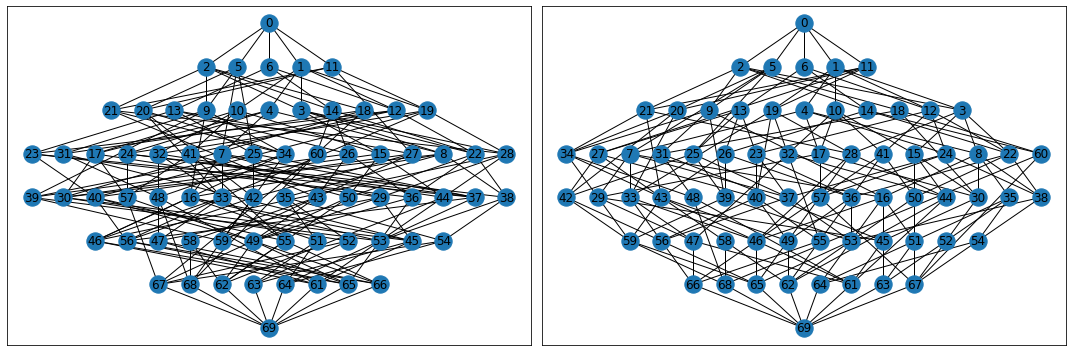

In [427]:
plt.figure(figsize=(15,5))
plt.subplot(121)
nx.draw_networkx(G, pos_old)

plt.subplot(122)
nx.draw_networkx(G, pos)

plt.tight_layout()
plt.show()

In [428]:
A = nx.adjacency_matrix(G).todense()

In [429]:
cm = nx.utils.reverse_cuthill_mckee_ordering(G)

In [430]:
l = [n for n in cm]

In [431]:
A_new = nx.to_numpy_matrix(G)
A_new = np.asarray(A_new)
# apply reordering
A_new = A_new[np.ix_(l,l)]

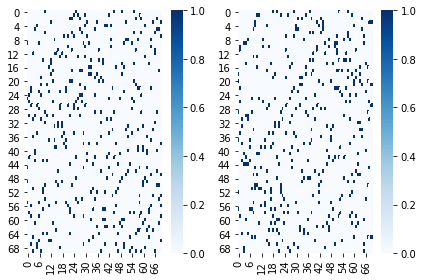

In [432]:
plt.subplot(121)
sns.heatmap(A, cmap='Blues')

plt.subplot(122)
sns.heatmap(A_new, cmap='Blues')

plt.tight_layout()
plt.show()

In [351]:
max_width = max(level_widths.values())
max_height = max(nodes_by_level_dict.keys())
max_width, max_height

(16, 6)

In [363]:
c.get_lower_neighbs()

{1, 2, 5, 6, 11}

In [435]:
all_upper_neighbs = {}
all_lower_neighbs = {}
for c in tqdm(fm.sort_concepts()):
    ln_ids = c.get_lower_neighbs()
    up_ids = c.get_upper_neighbs()
    all_upper_neighbs[c.get_id()] = list(up_ids)+list(set([
        all_up_id for up_id in up_ids for all_up_id in all_upper_neighbs[up_id]]))
    all_lower_neighbs[c.get_id()] = set(ln_ids)
    for c_id in all_upper_neighbs[c.get_id()]: 
        all_lower_neighbs[c_id] |= set(ln_ids)

In [442]:
(pd.Series({k:len(ns) for k,ns in all_lower_neighbs.items()})\
 +pd.Series({k:len(ns) for k,ns in all_upper_neighbs.items()})).sort_values(ascending=False)

69    69
0     69
1     46
2     41
65    40
      ..
41    12
32    12
57    12
31    11
60     8
Length: 70, dtype: int64

In [462]:
all_neighbs = {c.get_id():
               list(all_lower_neighbs[c.get_id()])+list(all_upper_neighbs[c.get_id()]) for c in fm.get_concepts()}

In [448]:
G_new = nx.from_dict_of_lists(all_neighbs)

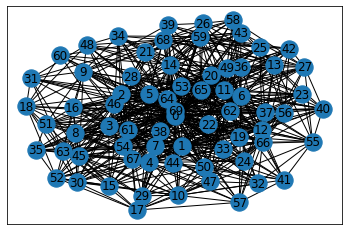

In [453]:
nx.draw_networkx(G_new, pos=nx.spring_layout(G_new))

In [454]:
A_new = nx.to_numpy_matrix(G_new)
A_new = np.asarray(A_new)
# apply reordering

A_new = A_new[np.ix_(l,l)]

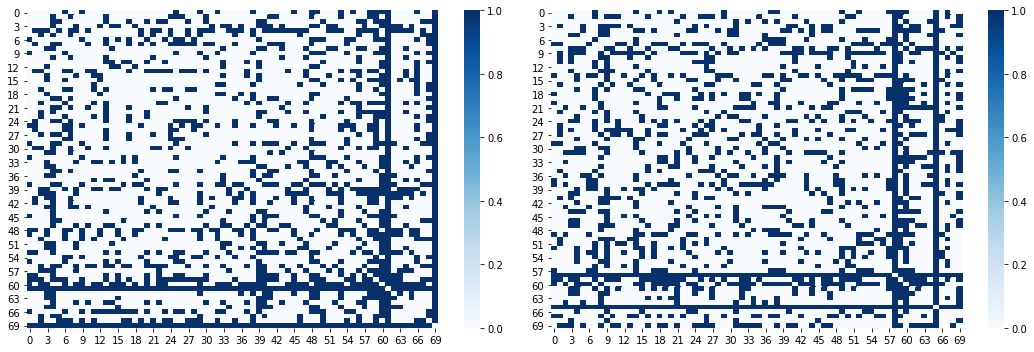

In [459]:
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.heatmap(nx.adjacency_matrix(G_new).todense(), cmap='Blues')

plt.subplot(122)
sns.heatmap(A_new, cmap='Blues')

plt.tight_layout()
plt.show()

In [471]:
all_neighbs_count = list(pd.Series({k:len(vs) for k,vs in all_neighbs.items()}).sort_values(ascending=False).index)
all_neighbs_count[:5]

[69, 0, 1, 2, 65]

In [549]:
connections_dict = {}
for c in fm.get_concepts():
    connections_dict[c.get_id()] = [ln_idx for ln_idx in c.get_lower_neighbs()]
level_widths = {}
nodes_by_level_dict = {}
for c in fm.get_concepts():
    lvl = c.get_level()
    level_widths[lvl] = level_widths.get(lvl, 0) + 1
    nodes_by_level_dict[lvl] = nodes_by_level_dict.get(lvl, []) + [c.get_id()]

In [552]:
max_width = max(level_widths.values())
max_width += 1-max_width%2
max_height = max(nodes_by_level_dict.keys())
x_center = max_width//2
max_width, max_height, x_center

(17, 7, 8)

In [553]:
grid = np.array([(j,-i) for j in range(max_width) for i in range(max_height+1)])

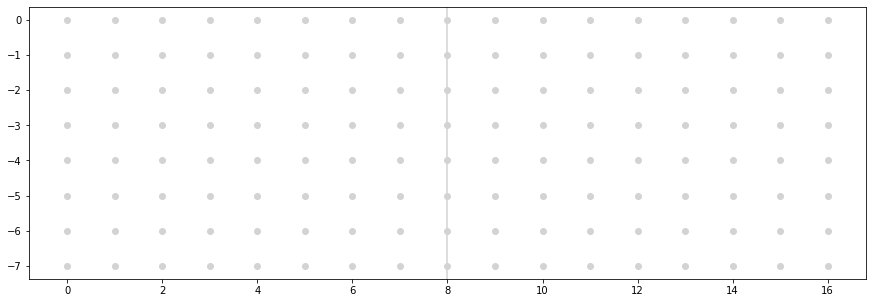

In [554]:
plt.figure(figsize=(15,5))
plt.scatter(grid[:,0], grid[:,1], color='lightgrey')
plt.axvline(x_center, color='lightgrey')
#nx.draw_networkx_nodes(G, pos)

In [555]:
nodes_added = []
pos = {}

In [556]:
v = all_neighbs_count[0]
c = fm.get_concept_by_id(v)
v, c.get_level()

(69, 7)

In [557]:
fm.get_concept_by_id(0).get_level()

0

In [558]:
c.get_level()

7

In [561]:
nodes = nodes_added+[c.get_id()]
nodes

[69]

In [477]:
fm.get_concept_by_id(69).get_level()

7